## Import Data and Libraries

In [1]:
# standard
import os
import pandas as pd
import numpy as np

# sklearn - preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# sklearn - cross validation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# sklearn - metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix
# sklearn fixed random state
rs = 7
# xgboost
import xgboost as xgb

#plotting
import seaborn as sn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Attribute information from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
"""
Attribute Information:

Only 14 attributes used:
1. #3 (age) -> numerical
2. #4 (sex) -> binary
3. #9 (cp) -> ordinal or categorical
4. #10 (trestbps) -> numerical
5. #12 (chol) -> numerical
6. #16 (fbs) -> binary
7. #19 (restecg) -> ordinal or categorical
8. #32 (thalach) -> numerical
9. #38 (exang) -> binary
10. #40 (oldpeak) -> numerical
11. #41 (slope) -> ordinal
12. #44 (ca) -> oridinal or numeric 
13. #51 (thal) -> ordinal or categorical
14. #58 (num) (the predicted attribute) will transform to binary
"""
headers = ['age',
          'sex',
          'cp',
          'trestbps',
          'chol',
          'fbs',
          'restecg',
          'thalach',
          'exang',
          'oldpeak',
          'slope',
          'ca',
          'thal',
          'diagnosis'
          ]

In [3]:
# Import the data
clev_data = pd.read_csv("Data/processed.cleveland.data", names=headers)
print("the dataset has %d patients" % len(clev_data[clev_data.isna()]))
display(clev_data.head())

the dataset has 303 patients


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Data preprocessing

### Data preprocessing - part 1

In [4]:
#Checks
# Data types - we expect to have a mix of floats and integers
print(clev_data.dtypes)

age          float64
sex          float64
cp           float64
trestbps     float64
chol         float64
fbs          float64
restecg      float64
thalach      float64
exang        float64
oldpeak      float64
slope        float64
ca            object
thal          object
diagnosis      int64
dtype: object


In [5]:
# Check the columns with type object
print(clev_data['ca'].unique())
print(clev_data['thal'].unique())

['0.0' '3.0' '2.0' '1.0' '?']
['6.0' '3.0' '7.0' '?']


In [6]:
# ? should be turned into nan and the data types to integers
clev_data[clev_data['ca']=='?'] = np.nan
clev_data[clev_data['thal']=='?'] = np.nan
# Convert them to floats
clev_data = clev_data.astype({'ca': 'float64', 'thal': 'float64'})
# Now that everything is numerical, check for missing values
clev_data.isna().sum()

age          6
sex          6
cp           6
trestbps     6
chol         6
fbs          6
restecg      6
thalach      6
exang        6
oldpeak      6
slope        6
ca           6
thal         6
diagnosis    6
dtype: int64

In [7]:
# Given that these are only 6 observations and they are ordinal/categorical variables,
# we'll remove these observations from the dataset
clev_data = clev_data.dropna()

# Correct the data types e.g. sex -> int
clev_data = clev_data.astype({'age': 'int64', 
                              'sex': 'int64',
                              'cp': 'int64',
                              'fbs': 'int64',
                              'exang': 'int64',
                              'restecg': 'int64',
                              'slope': 'int64',
                              'thal': 'int64',
                              'diagnosis': 'int64'
                             })
# Adjust data types based on the attribute description
print(clev_data.dtypes)

age            int64
sex            int64
cp             int64
trestbps     float64
chol         float64
fbs            int64
restecg        int64
thalach      float64
exang          int64
oldpeak      float64
slope          int64
ca           float64
thal           int64
diagnosis      int64
dtype: object


In [8]:
# Tranform diagnosis into binary 0: No heart disease; 1:Heart disease (1,2,3,4)
# Hence we'll turn this into a binary classification problem
clev_data['diagnosis'] = clev_data['diagnosis'].map({0:0, 1:1, 2:1, 3:1, 4:1})
# Check
print(clev_data['diagnosis'].unique())

[0 1]


In [9]:
# One hot encode nominal variables

### Data Exploration

C:\Users\leoni\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B04C8B688>,
      dtype=object)

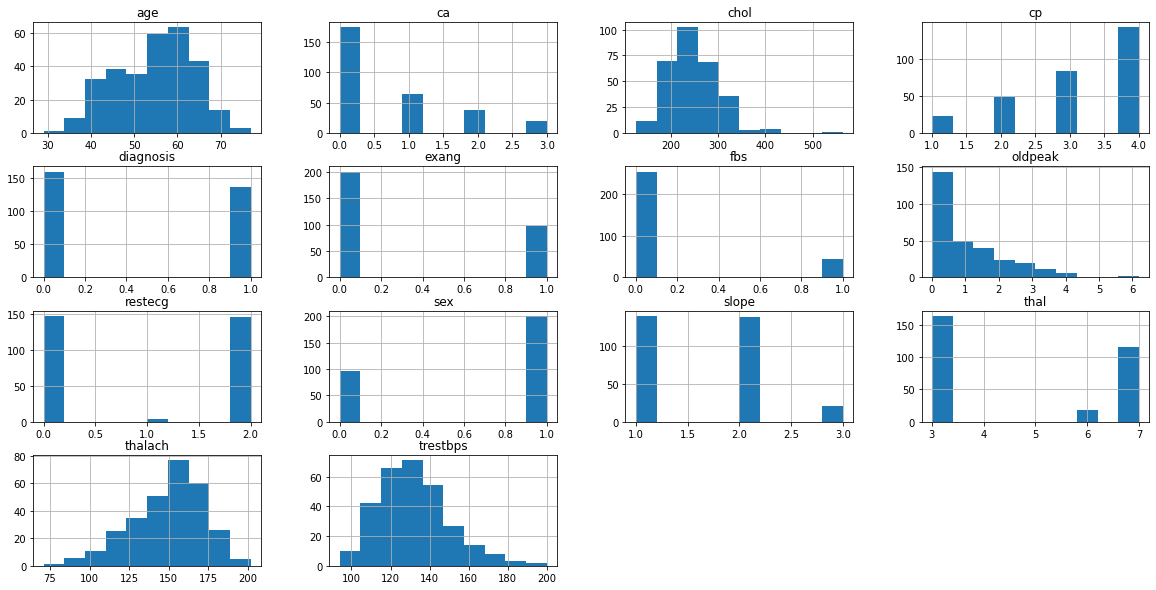

In [10]:
# Plot histograms of all the attributes
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
clev_data.hist(ax = ax)

In [11]:
# Check for class imbalances in target variable
# If we find class imbalances in the target we'll need to consider oversampling 
# undersampling won't be a good option since we only have 300 data points
pos = clev_data['diagnosis'].sum()
neg = len(clev_data) - pos
print('%d patients with heart decease and %d negatives'%(pos, neg))

137 patients with heart decease and 160 negatives


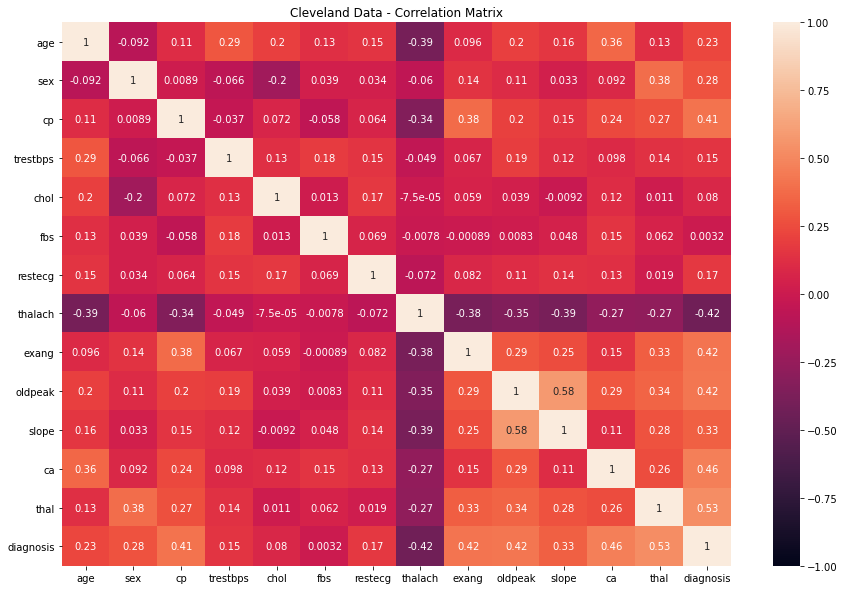

In [12]:
# Plot correlation matrix, for a few if the classifiers we'll use 
# correlation between predictors will greatly decrease their performance
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
plt.title('Cleveland Data - Correlation Matrix')
sn.heatmap(clev_data.corr(), vmin=-1, vmax=1, annot=True)

### Data preprocessing - part 2

In [13]:
# Train test splits
# Best practice is to split the data into train, and test splits 
# But, we'll use the sklearn cross validation for hyperparameter tunning via gridsearch thus we don't need a dev set
X = clev_data.drop(columns=['diagnosis'])
Y = clev_data['diagnosis']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = rs)
print("%d in the test and %d in the train set" %(len(X_test), len(X_train)))
display(X_train.head())
display(Y_train.head())

60 in the test and 237 in the train set


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
170,70,1,3,160.0,269.0,0,0,112.0,1,2.9,2,1.0,7
109,39,1,4,118.0,219.0,0,0,140.0,0,1.2,2,0.0,7
95,52,1,4,128.0,255.0,0,0,161.0,1,0.0,1,1.0,7
140,59,1,2,140.0,221.0,0,0,164.0,1,0.0,1,0.0,3
81,53,0,4,130.0,264.0,0,2,143.0,0,0.4,2,0.0,3


170    1
109    1
95     1
140    0
81     0
Name: diagnosis, dtype: int64

In [14]:
# Create an instance of the data set where the data are normalised (min max)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
# Note: for X_test we use the min max normaliser fitted on X_train
X_test_sc = scaler.transform(X_test)

## Models

### 1. Logistic Regression

In [15]:
logit = LogisticRegression(random_state=rs)
# Try different values of the regularisation penalty
params = {'C': [0.1, 1, 10, 100]}
# Score roc_auc or accuracy?
gs_logit = GridSearchCV(logit, param_grid=params, scoring='roc_auc', cv=5)
# use scaled version of train set 
gs_logit.fit(X_train_sc, Y_train)
print('The train set auc of the best estimator is %0.2f' % gs_logit.best_score_)

The train set auc of the best estimator is 0.92


In [16]:
logit_coefs = pd.DataFrame()
logit_coefs['feature'] = headers[:-1]
logit_coefs['coefficient'] = gs_logit.best_estimator_.coef_.reshape(-1)
logit_coefs['odds ratio'] = np.exp(logit_coefs['coefficient'])
logit_coefs = logit_coefs.sort_values(by=['odds ratio'], ascending=False)
display(logit_coefs)
logit_coefs.to_csv('LR_odds_ratios.csv')

,feature,coefficient,odds ratio
11,ca,4.068932,58.494451
3,trestbps,2.636319,13.961718
4,chol,2.342230,10.404412
12,thal,1.632615,5.117238
2,cp,1.539012,4.659984
10,slope,1.530233,4.619251
1,sex,1.237006,3.445281
9,oldpeak,1.070091,2.915645
8,exang,0.790385,2.204245
6,restecg,0.528976,1.697193


In [17]:
logit_fpr, logit_tpr, _ = roc_curve(Y_test, gs_logit.predict_proba(X_test_sc)[:,1])
logit_roc_auc = auc(logit_fpr, logit_tpr)
accuracy = accuracy_score(Y_test, gs_logit.predict(X_test_sc))
print("The roc auc in the test set is %0.2f and the accuracy is %0.2f"
      %(logit_roc_auc, accuracy))

The roc auc in the test set is 0.89 and the accuracy is 0.80


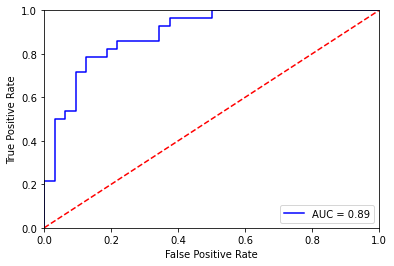

In [18]:
# Plotting the graph
plt.plot(logit_fpr, logit_tpr, 'b', label = 'AUC = %0.2f' % logit_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

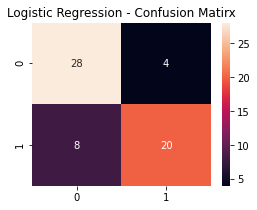

In [19]:
# Confusion matrix
cf = confusion_matrix(Y_test, gs_logit.predict(X_test_sc))
fig = plt.figure(figsize = (4,3))
plt.title('Logistic Regression - Confusion Matirx')
ax = fig.gca()
sn.heatmap(cf, annot=True)

### 2. Random Forest

In [20]:
# For the random forest scaling is not essential thus we'll use the non scaled version of the dataset
rf = RandomForestClassifier(random_state=rs)
# Try different values of the estimators and max depth
params = {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth': [None, 5, 10, 20]}
# Score roc_auc or accuracy?
gs_rf = GridSearchCV(rf, param_grid=params, scoring='roc_auc', cv=5)
gs_rf.fit(X_train, Y_train)
print('The train set auc of the best estimator is %0.2f' % gs_rf.best_score_)

The train set auc of the best estimator is 0.92


In [21]:
rf_feature_importance = pd.DataFrame()
rf_feature_importance['fearure'] = headers[:-1]
rf_feature_importance['fearure importance'] = gs_rf.best_estimator_.feature_importances_
rf_feature_importance = rf_feature_importance.sort_values(by=['fearure importance'], ascending=False)
display(rf_feature_importance)
rf_feature_importance.to_csv('Random_Forest_FI.csv')

,fearure,fearure importance
12,thal,0.176319
11,ca,0.135903
2,cp,0.127602
9,oldpeak,0.106043
7,thalach,0.102825
0,age,0.067840
4,chol,0.064810
8,exang,0.058855
3,trestbps,0.056257
10,slope,0.051026


In [22]:
rf_fpr, rf_tpr, _ = roc_curve(Y_test, gs_rf.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
accuracy = accuracy_score(Y_test, gs_rf.predict(X_test))
print("The roc auc in the test set is %0.2f and the accuracy is %0.2f"
      %(rf_roc_auc, accuracy))

The roc auc in the test set is 0.89 and the accuracy is 0.77


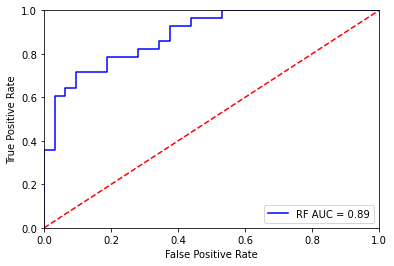

In [23]:
# Plotting the graph
plt.plot(rf_fpr, rf_tpr, 'b', label = 'RF AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

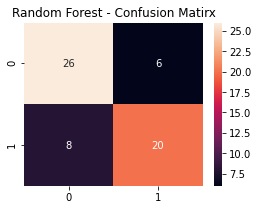

In [24]:
# Confusion matrix
cf = confusion_matrix(Y_test, gs_rf.predict(X_test))
fig = plt.figure(figsize = (4,3))
plt.title('Random Forest - Confusion Matirx')
ax = fig.gca()
sn.heatmap(cf, annot=True)

 ### 3. XGBoost

In [25]:
xgbc = xgb.XGBClassifier()
params = {'min_child_weight': [1, 5, 10],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3,5,7,10]}
# Score roc_auc or accuracy?
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='roc_auc', cv=5)
gs_xgbc.fit(X_train, Y_train)
print('The train set auc of the best estimator is %0.2f' % gs_xgbc.best_score_)

The train set auc of the best estimator is 0.91


In [26]:
xgbc_fpr, xgbc_tpr, _ = roc_curve(Y_test, gs_xgbc.predict_proba(X_test)[:,1])
xgbc_roc_auc = auc(xgbc_fpr, xgbc_tpr)
accuracy = accuracy_score(Y_test, gs_xgbc.predict(X_test))
print("The roc auc in the test set is %0.2f and the accuracy is %0.2f"
      %(xgbc_roc_auc, accuracy))

The roc auc in the test set is 0.88 and the accuracy is 0.80


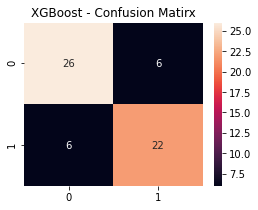

In [27]:
# Confusion matrix
cf = confusion_matrix(Y_test, gs_xgbc.predict(X_test))
fig = plt.figure(figsize = (4,3))
plt.title('XGBoost - Confusion Matirx')
ax = fig.gca()
sn.heatmap(cf, annot=True)

In [28]:
xgbc_feature_importance = pd.DataFrame()
xgbc_feature_importance['fearure'] = headers[:-1]
xgbc_feature_importance['fearure importance'] = gs_xgbc.best_estimator_.feature_importances_
xgbc_feature_importance = xgbc_feature_importance.sort_values(by=['fearure importance'], ascending=False)
display(xgbc_feature_importance)
xgbc_feature_importance.to_csv('XGBoost_FI.csv')

,fearure,fearure importance
8,exang,0.228893
11,ca,0.166368
10,slope,0.127194
1,sex,0.106116
12,thal,0.106058
2,cp,0.104059
9,oldpeak,0.033756
7,thalach,0.031583
0,age,0.025634
4,chol,0.025613


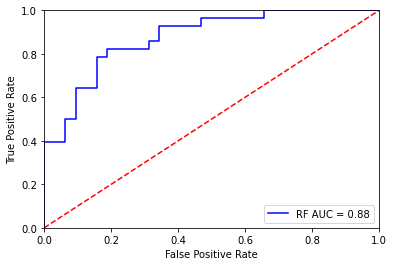

In [29]:
# Plotting the graph
plt.plot(xgbc_fpr, xgbc_tpr, 'b', label = 'RF AUC = %0.2f' % xgbc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### All Classiffiers ROC curve

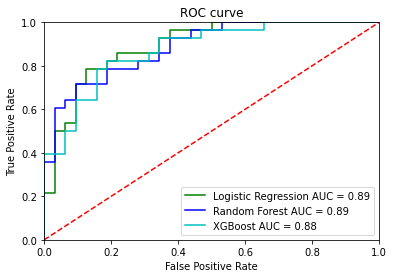

In [30]:
plt.plot(logit_fpr, logit_tpr, 'g', label = 'Logistic Regression AUC = %0.2f' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, 'b', label = 'Random Forest AUC = %0.2f' % rf_roc_auc)
plt.plot(xgbc_fpr, xgbc_tpr, 'c', label = 'XGBoost AUC = %0.2f' % xgbc_roc_auc)
plt.legend(loc = 'lower right')
plt.title('ROC curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()